In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import os
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
from tensorflow.random import set_seed
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from tensorflow.keras.applications import ResNet101V2

Affichage du GPU utilisé, fourni par la machine executant tensorflow:

In [3]:
tf.test.gpu_device_name()
!nvidia-smi

Tue Apr  5 10:33:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   35C    P2    39W / 200W |   1109MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Rendre stochastique avec une graine changeante  -  

In [4]:
import time
pd.options.display.max_colwidth = 100
SEED = int(time.time())
print("On utilise le seed", SEED)
seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(SEED)
warnings.filterwarnings('ignore')

On utilise le seed 1649169201


**Pour 19 classes**

In [5]:
absolute_path = os.path.abspath(os.curdir)
main_path = "drive/MyDrive/tni/archive"
main_path = os.path.join(absolute_path, main_path)
train_path = os.path.join(main_path,"train")

import os

filenames= os.listdir(train_path) # Récuperer les sous dossiers dans le chemin
names = []
for filename in filenames: # Attribuer un dossier à chaque nom
    names.append(filename)
names.sort()
train_list = []
for name in names:
  train_list.extend(glob.glob(train_path+"/"+name+"/*.jpg"))


In [6]:

#Construction d'un dataframe montrant les longueurs de chaques labels

name_img_counts = {}
for name in names:
  name_img_counts[name] = len(os.listdir(train_path+"/"+name))
print(name_img_counts)

np_array = []
for name in names:
  np_array = np.append(
      np_array, [(name[:8] + '..') if len(name) > 8 else name]*name_img_counts[name]
  )

df_train = pd.DataFrame(np_array, columns = ['label'])
df_train['image'] = [x for x in train_list]

{'abraham_grampa_simpson': 713, 'apu_nahasapeemapetilon': 423, 'bart_simpson': 1142, 'charles_montgomery_burns': 993, 'chief_wiggum': 786, 'comic_book_guy': 269, 'edna_krabappel': 257, 'homer_simpson': 2046, 'kent_brockman': 298, 'krusty_the_clown': 1006, 'lenny_leonard': 110, 'lisa_simpson': 1154, 'marge_simpson': 1091, 'milhouse_van_houten': 879, 'moe_szyslak': 1252, 'ned_flanders': 1254, 'nelson_muntz': 158, 'principal_skinner': 994, 'sideshow_bob': 677}


Visualisons le dataframe

In [7]:
df_train

,label,image
0,abraham_..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/abraham_grampa_simpson\pic_0000.jpg
1,abraham_..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/abraham_grampa_simpson\pic_0002.jpg
2,abraham_..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/abraham_grampa_simpson\pic_0004.jpg
3,abraham_..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/abraham_grampa_simpson\pic_0005.jpg
4,abraham_..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/abraham_grampa_simpson\pic_0006.jpg
...,...,...
15497,sideshow..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/sideshow_bob\pic_0871.jpg
15498,sideshow..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/sideshow_bob\pic_0872.jpg
15499,sideshow..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/sideshow_bob\pic_0874.jpg
15500,sideshow..,C:\Users\Thiba\drive/MyDrive/tni/archive\train/sideshow_bob\pic_0875.jpg


Distribution des images par labels

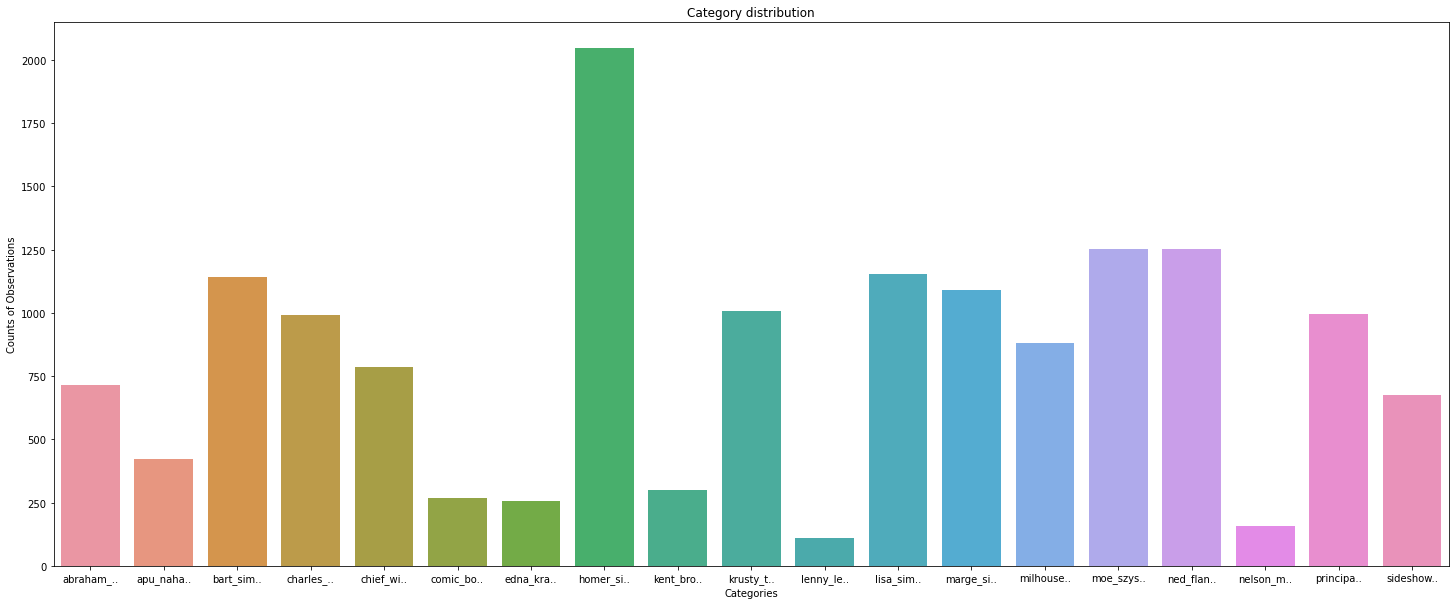

In [8]:
f = plt.figure(1,figsize=(25,10))
sns.countplot(df_train['label'])
plt.title('Category distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of Observations');

In [9]:
path = main_path+'/train'
#List of image:
img_list = list(df_train['image'])
data_img = []
for each in img_list:
    #Each image path:
    each_path = os.path.join(path, each)
    #Read each image:
    each_img = plt.imread(each_path)
    #Resize the images:
    each_img_resized = cv2.resize(each_img, (128,128))
    #Save arrays to a list:
    data_img.append(each_img_resized)
# Converting list to numpy array
X = np.array(data_img)

In [10]:
print('Shape of X: ', X.shape)

Shape of X:  (15502, 128, 128, 3)


Affichons nos images

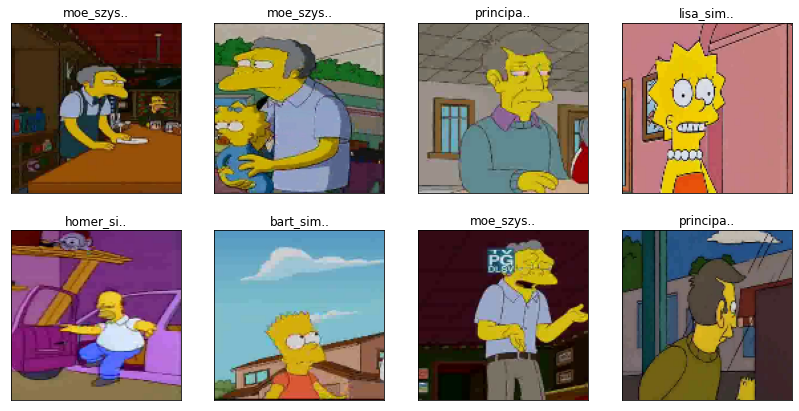

In [11]:
indices = np.random.randint(0, X.shape[0],8)
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(df_train['label'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

# Entrainement d'un CNN


Création d'un Tenseur avec nos labels


In [12]:
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (15502, 19)


Il est maintenant nécessaire de séparer nos données en un set de training et un set de validation

In [13]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (10540, 128, 128, 3)
y_train shape:  (10540, 19)
X_val shape  :  (2636, 128, 128, 3)
y_val shape  :  (2636, 19)
X_test shape :  (2326, 128, 128, 3)
y_test shape :  (2326, 19)


Enfin, pour s'assurer de données variées, on applique des transformations aléatoires à nos images

In [14]:
train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
train_gen.fit(X_train)
validation_gen.fit(X_val)

# Partie 2 - Entrainement du modele


In [15]:
#Note : on peut baisser le batch size et monter le nombre d'epochs pour maximiser l'accuracy (attention lent / utilise plus de ram)
batch_size = 64
epochs = 35
nb_categories = y.shape[1] #Le nombre de catégories
print("nb categories =",nb_categories)

nb categories = 19


Définissons notre modèle, ici nous utiliserons **ResNet101V2** qui est un bon compromis entre vitesse et efficacité

In [16]:
#from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
#base1 = Xception(include_top=False, 
#                weights='imagenet', 
#                input_shape=(128,128,3))
base = ResNet101V2(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
#base3 = InceptionV3(include_top=False, 
#                weights='imagenet', 
#                input_shape=(128,128,3))
#base2 = InceptionResNetV2(include_top=False, 
#                weights='imagenet', 
#                 input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)

Définissons la couche d'entrée du modèle

In [17]:
head = Dense(nb_categories, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)

Compilation du modèle

In [18]:
model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)

In [19]:
# Affichage d'un résumé de l'architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

conv5_block1_2_conv (Conv2D)    (None, 4, 4, 512)    2359296     conv5_block1_2_pad[0][0]         
__________________________________________________________________________________________________
conv5_block1_2_bn (BatchNormali (None, 4, 4, 512)    2048        conv5_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_2_relu (Activation (None, 4, 4, 512)    0           conv5_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block1_0_conv (Conv2D)    (None, 4, 4, 2048)   2099200     conv5_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_block1_3_conv (Conv2D)    (None, 4, 4, 2048)   1050624     conv5_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_bloc

# Partie 3 - Entrainons le modèle!


In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(  # - A traduire 
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
history = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val),
               callbacks = callbacks
)

Epoch 1/35
165/165 [==============================] - 83s 475ms/step - loss: 2.0156 - accuracy: 0.4009 - val_loss: 1.5875 - val_accuracy: 0.6119
Epoch 2/35
165/165 [==============================] - 79s 476ms/step - loss: 1.0554 - accuracy: 0.6944 - val_loss: 1.0192 - val_accuracy: 0.7060
Epoch 3/35
165/165 [==============================] - 81s 493ms/step - loss: 0.8469 - accuracy: 0.7565 - val_loss: 0.8085 - val_accuracy: 0.7618
Epoch 4/35
165/165 [==============================] - 81s 490ms/step - loss: 0.7266 - accuracy: 0.7870 - val_loss: 0.8154 - val_accuracy: 0.7656
Epoch 5/35
165/165 [==============================] - 80s 483ms/step - loss: 0.6664 - accuracy: 0.8032 - val_loss: 0.7124 - val_accuracy: 0.7936
Epoch 6/35
165/165 [==============================] - 78s 472ms/step - loss: 0.6051 - accuracy: 0.8243 - val_loss: 0.7515 - val_accuracy: 0.7815
Epoch 7/35
165/165 [==============================] - 80s 484ms/step - loss: 0.5525 - accuracy: 0.8344 - val_loss: 0.6477 - val_ac

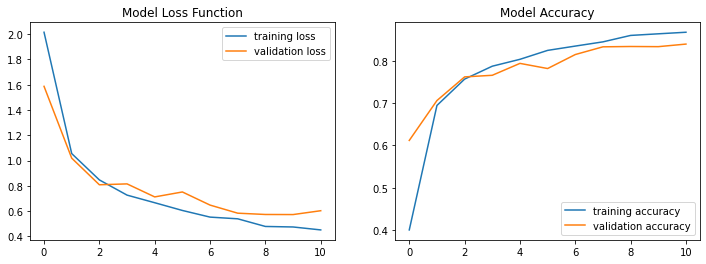

In [22]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();

Affichage de la matrice de confusion

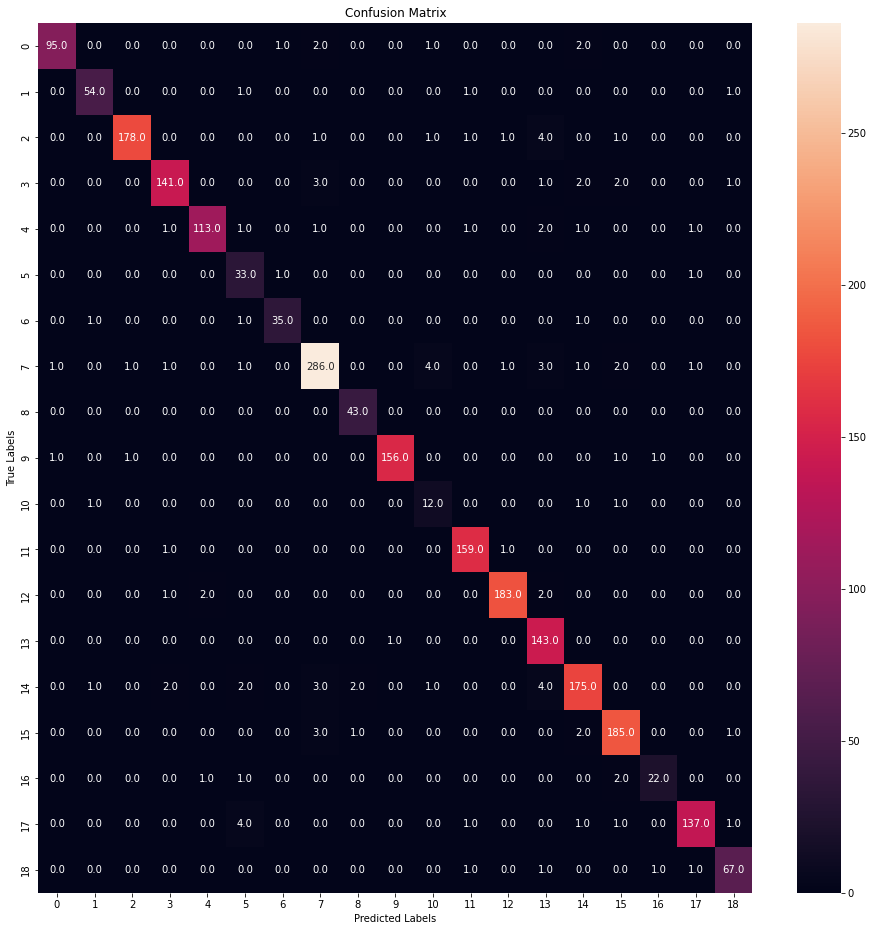

In [23]:
# Predicting labels from X_test data
y_pred = model.predict(X_test)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)
# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (16,16))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [24]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       101
           1       0.95      0.95      0.95        57
           2       0.99      0.95      0.97       187
           3       0.96      0.94      0.95       150
           4       0.97      0.93      0.95       121
           5       0.75      0.94      0.84        35
           6       0.95      0.92      0.93        38
           7       0.96      0.95      0.95       302
           8       0.93      1.00      0.97        43
           9       0.99      0.97      0.98       160
          10       0.63      0.80      0.71        15
          11       0.97      0.99      0.98       161
          12       0.98      0.97      0.98       188
          13       0.89      0.99      0.94       144
          14       0.94      0.92      0.93       190
          15       0.95      0.96      0.96       192
          16       0.92      0.85      0.88        26
          17       0.97    

Evaluation du potentiel d'under / overfitting

In [25]:
# Kappa score evaluation
cohen_kappa_score(y_test_classes, y_pred_classes)

0.9495309596490931

In [26]:
test_loss = model.evaluate(X_test, y_test)

73/73 [==============================] - 5s 73ms/step - loss: 0.1815 - accuracy: 0.9531


In [27]:
test_loss = model.evaluate(X_val, y_val)

83/83 [==============================] - 6s 75ms/step - loss: 0.1690 - accuracy: 0.9522


On Enregistre le modèle entrainé au format H5

In [29]:
# Save the entire model as a SavedModel.
model.save('drive/MyDrive/tni/saved_models/my_model.h5')